<a id='top'></a>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# %matplotlib nbagg 
%matplotlib notebook
# %matplotlib inline



## Third party 
import numpy as np
import os, time, zarr, sys
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import unslice.IO as io
from unslice.utils import *
from unslice.registration.featmatch import *
from unslice.registration.transform import *
from unslice.registration.rigid import *
from unslice.registration.gpu_transform import *
from unslice.registration.utils import *
from unslice.segmentation import *
from unslice.tracing.pyoof import OOF, apply_oof_v2
from unslice.tracing.skel import *
from unslice.flatten import *
from unslice.lightsheetcorrect import *




In [2]:
# Parameters that are constant throughout notebook
working_dir = '/mnt/share3/webster/mEhmAD_1-3_real'

def bdir(fname):
    return os.path.join(working_dir, fname)

# prefix to add to the beginning of each filename 
name_prefix = '1-ptau_cropped' 
name_prefix2 = '3-ptau_cropped' 

In [38]:
anchors_json_path = bdir('manual_labels/ptau_labels_cropped_frame.json')
annotation_names = ['1-pts']
resample_factor = (1,)*3 # multiply this by the anchor points to get to correct reference frame 
offset = (0,0,1500) # subtract these to get the actual reference frame (subtracted pre-resampling)
surf_eps_save_path = bdir('manual_labels/'+name_prefix+'_endpoints.npy') # where to save surface points 

# ranges for filtering (not downsampled)
xrange = None
yrange = None
zrange = None



##############################
pts = np.zeros((0,3),dtype='float')
for annotation_name in annotation_names:
    pts_temp = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
    pts = np.concatenate((pts,pts_temp),axis=0)

if xrange is not None:
    pts = pts[(pts[:,0]>=xrange[0]) * (pts[:,0]<xrange[1])]
if yrange is not None:
    pts = pts[(pts[:,1]>=yrange[0]) * (pts[:,1]<yrange[1])]
if zrange is not None:
    pts = pts[(pts[:,2]>=zrange[0]) * (pts[:,2]<zrange[1])]

pts[:,0] -= offset[0]; pts[:,1] -= offset[1]; pts[:,2] -= offset[2]
pts[:,0] *= resample_factor[0]; pts[:,1] *= resample_factor[1]; pts[:,2] *= resample_factor[2]
pts = np.round(pts).astype('int')

np.save(surf_eps_save_path, pts)
print(pts.shape)

print(pts[:,0].min(),pts[:,0].max())
print(pts[:,1].min(),pts[:,1].max())
print(pts[:,2].min(),pts[:,2].max())

(162, 3)
57 2517
56 1325
65 149


In [25]:
anchors_json_path = bdir('manual_labels/ptau_labels_cropped_frame.json')
annotation_names = ['3-pts']
resample_factor = (1,)*3 # multiply this by the anchor points to get to correct reference frame 
offset = (0,0,1500) # subtract these to get the actual reference frame (subtracted pre-resampling)
surf_eps_save_path = bdir('manual_labels/'+name_prefix2+'_endpoints.npy') # where to save surface points 

# ranges for filtering (not downsampled)
xrange = None
yrange = None
zrange = None



##############################
pts = np.zeros((0,3),dtype='float')
for annotation_name in annotation_names:
    pts_temp = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
    pts = np.concatenate((pts,pts_temp),axis=0)

if xrange is not None:
    pts = pts[(pts[:,0]>=xrange[0]) * (pts[:,0]<xrange[1])]
if yrange is not None:
    pts = pts[(pts[:,1]>=yrange[0]) * (pts[:,1]<yrange[1])]
if zrange is not None:
    pts = pts[(pts[:,2]>=zrange[0]) * (pts[:,2]<zrange[1])]

pts[:,0] -= offset[0]; pts[:,1] -= offset[1]; pts[:,2] -= offset[2]
pts[:,0] *= resample_factor[0]; pts[:,1] *= resample_factor[1]; pts[:,2] *= resample_factor[2]
pts = np.round(pts).astype('int')

np.save(surf_eps_save_path, pts)
print(pts.shape)
print(pts[:,0].min(),pts[:,0].max())
print(pts[:,1].min(),pts[:,1].max())
print(pts[:,2].min(),pts[:,2].max())

(162, 3)
43 2537
9 1328
41 159


#### 2. Unwarp moving endpoints back to flattened frame

In [26]:
# Warp the moving points back to flattened frame 
grid_path = bdir('warping_grids/grid_anchor_tps_r1_upsampled.npy')

pts_path = bdir('manual_labels/'+name_prefix2+'_endpoints.npy')
warped_zarr_path = bdir('3-ptau_flattened_anchorwarp_r1.zarr')
save_path = bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe.npy')
save_json = False 
inverse_transform = False


#####
g = np.load(pts_path)
g[:,0] += 5759; g[:,1] += 5981; g[:,2] += 4213 # since the points were already cropped

coords = grid_transform_pts(grid_path, g, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)# Transform moving points to flattened frame 

In [29]:
# We can find true "bounding box" by warping a bunch of points 
xrange = [5759,8410]
yrange = [5981,7328]
zrange = [4213,4213+2000]
num_pts = 8
X,Y,Z = np.meshgrid(np.linspace(xrange[0],xrange[1],num_pts),
           np.linspace(yrange[0],yrange[1],num_pts),
           np.linspace(zrange[0],zrange[1],num_pts))

grid_pts = np.vstack((X.ravel(),Y.ravel(),Z.ravel())).T

In [33]:
bbox = grid_transform_pts(grid_path, grid_pts, warped_zarr_path, save_path=None, save_json=False, inverse_transform=inverse_transform)

### From below we get how much to crop the original flattened moving image

In [34]:
print(bbox[:,0].min(),bbox[:,0].max())
print(bbox[:,1].min(),bbox[:,1].max())
print(bbox[:,2].min(),bbox[:,2].max())

4845.298725676862 7741.953048822809
5816.436654052881 7372.422347384228
501.5869949070318 2414.833769464483


In [35]:
print(coords[:,0].min(),coords[:,0].max())
print(coords[:,1].min(),coords[:,1].max())
print(coords[:,2].min(),coords[:,2].max())

5021.504371877347 7527.670451507293
6008.195020474202 7207.853853847084
586.0343138098199 670.7090659149616


In [39]:
# Now we subtract appropriate amounts from each moving coordinate to get "local flattened coordinate"

coords[:,0] -= bbox[:,0].min(); coords[:,1] -= bbox[:,1].min(); coords[:,2] -= bbox[:,2].min()

np.save(save_path, coords)

### 6. crop moving flattened zarr 

In [41]:
# bounding box of moving in flat frame
xrange = [4845,7742]
yrange = [5816,7372]
zrange = [501,2415]
num_workers = 24
source_zarr_path = bdir('3-ptau_flattened.zarr')
sink_zarr_path = bdir(name_prefix2+'_flattened.zarr')



###############
crop_zarr(source_zarr_path, sink_zarr_path, xrange=xrange, yrange=yrange, zrange=zrange, 
          load_num_slices=None, num_workers=num_workers)

Processing chunk x:4845-7742, y:5816-7372, z:501-701


100%|██████████| 120/120 [00:08<00:00, 14.80it/s]

Processing chunk x:4845-7742, y:5816-7372, z:701-901



100%|██████████| 120/120 [00:09<00:00, 13.26it/s]

Processing chunk x:4845-7742, y:5816-7372, z:901-1101



100%|██████████| 120/120 [00:08<00:00, 14.04it/s]

Processing chunk x:4845-7742, y:5816-7372, z:1101-1301



100%|██████████| 120/120 [00:08<00:00, 13.81it/s]

Processing chunk x:4845-7742, y:5816-7372, z:1301-1501



100%|██████████| 120/120 [00:08<00:00, 13.59it/s]

Processing chunk x:4845-7742, y:5816-7372, z:1501-1701



100%|██████████| 120/120 [00:08<00:00, 13.89it/s]

Processing chunk x:4845-7742, y:5816-7372, z:1701-1901



100%|██████████| 120/120 [00:08<00:00, 14.27it/s]

Processing chunk x:4845-7742, y:5816-7372, z:1901-2101



100%|██████████| 120/120 [00:08<00:00, 13.82it/s]

Processing chunk x:4845-7742, y:5816-7372, z:2101-2301



100%|██████████| 120/120 [00:09<00:00, 13.09it/s]

Processing chunk x:4845-7742, y:5816-7372, z:2301-2415



100%|██████████| 120/120 [00:05<00:00, 22.94it/s]


In [40]:
tiff_path = bdir(name_prefix2+'_flattened.zarr')[:-5]+'_tiffs'
convert_zarr_to_tiff(bdir(name_prefix2+'_flattened.zarr'), tiff_path, num_workers=24)

Loading z 0 - 200


100%|██████████| 200/200 [00:18<00:00, 11.10it/s]


Loading z 200 - 400


100%|██████████| 200/200 [00:17<00:00, 11.29it/s]


Loading z 400 - 600


100%|██████████| 200/200 [00:17<00:00, 11.46it/s]


Loading z 600 - 800


100%|██████████| 200/200 [00:18<00:00, 11.11it/s]


Loading z 800 - 1000


100%|██████████| 200/200 [00:17<00:00, 11.37it/s]


Loading z 1000 - 1200


100%|██████████| 200/200 [00:17<00:00, 11.18it/s]


Loading z 1200 - 1400


100%|██████████| 200/200 [00:17<00:00, 11.40it/s]


Loading z 1400 - 1600


100%|██████████| 200/200 [00:17<00:00, 11.41it/s]


Loading z 1600 - 1800


100%|██████████| 200/200 [00:17<00:00, 11.16it/s]


Loading z 1800 - 1914


100%|██████████| 114/114 [00:09<00:00, 11.60it/s]


#### 7b. RANSAC

In [45]:
points_idxs_to_evaluate = None # new points to evaluate with RANSAC. Else, make None

moving_pts_paths = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe.npy')]
fixed_pts_paths =  [bdir('manual_labels/'+name_prefix+'_endpoints.npy')]


moving_save_path = bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.npy')
fixed_save_path = bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy')
error_threshold = 20
min_samples = None

radius = 400
voxel_size = (1,1.414,1)


##################
moving_ransac, fixed_ransac = apply_ransac_v2(moving_pts_paths, fixed_pts_paths, moving_save_path=moving_save_path, fixed_save_path=fixed_save_path, points_idxs_to_evaluate=points_idxs_to_evaluate,
                    error_threshold=error_threshold, min_samples=min_samples, radius=radius, voxel_size=voxel_size)

print(np.load(moving_pts_paths[0]).shape,moving_ransac.shape)

162it [00:01, 111.14it/s]

(162, 3) (116, 3)


#### 8. Rigid alignment

(162, 3) (162, 3)
-4.470909691160218


<IPython.core.display.Javascript object>


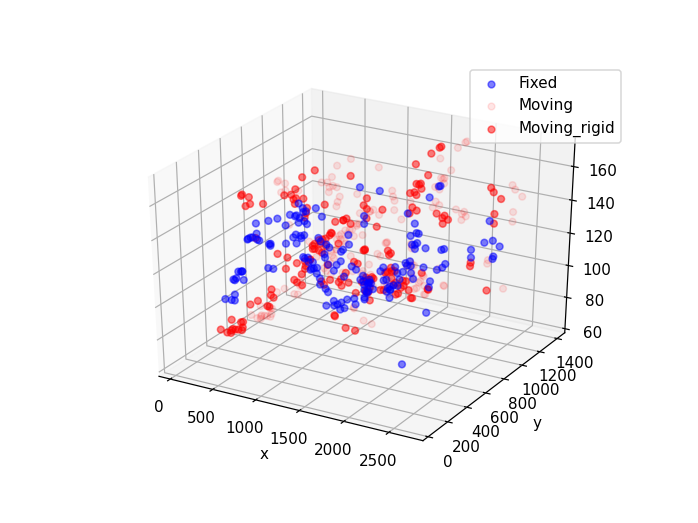

[[ 0.99680807 -0.07983526  0.        ]
 [ 0.07983526  0.99680807  0.        ]
 [ 0.          0.          1.        ]] [ -35.1452984  -274.23686717   -4.47090969]
average error: 32.7854244407697
average std: 15.386072545032967


In [63]:
# First do rigid alignment again

plot2d = False #True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
flattened_arteries_paths = [bdir('manual_labels/'+name_prefix+'_endpoints.npy')]
flattened_arteries_paths2 = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe.npy')]
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    #b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],flattened_arteries_2[:,2],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')
print(R,b)
print("average error:",np.mean(np.linalg.norm(new_points-flattened_arteries,axis=1)))
print("average std:",np.std(np.linalg.norm(new_points-flattened_arteries,axis=1)))

<IPython.core.display.Javascript object>


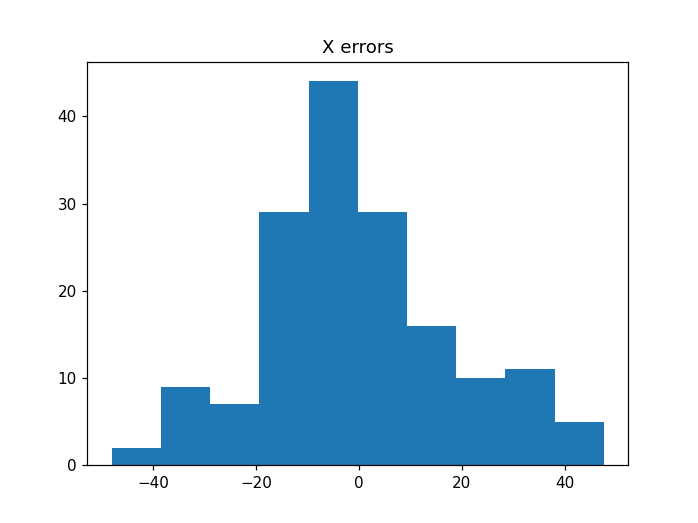

<IPython.core.display.Javascript object>


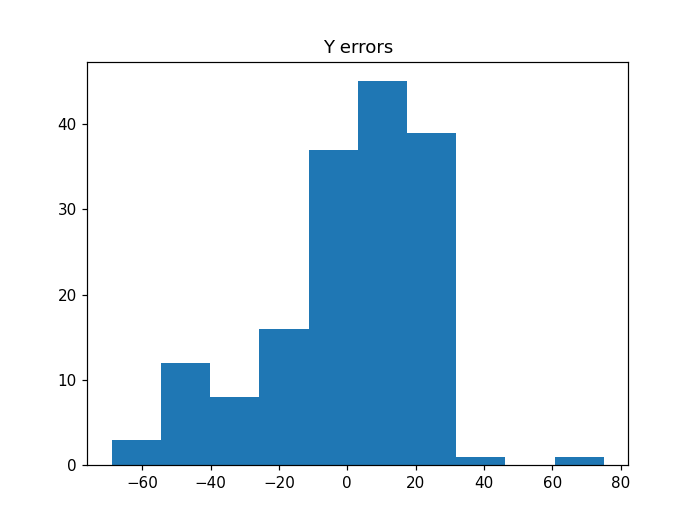

<IPython.core.display.Javascript object>


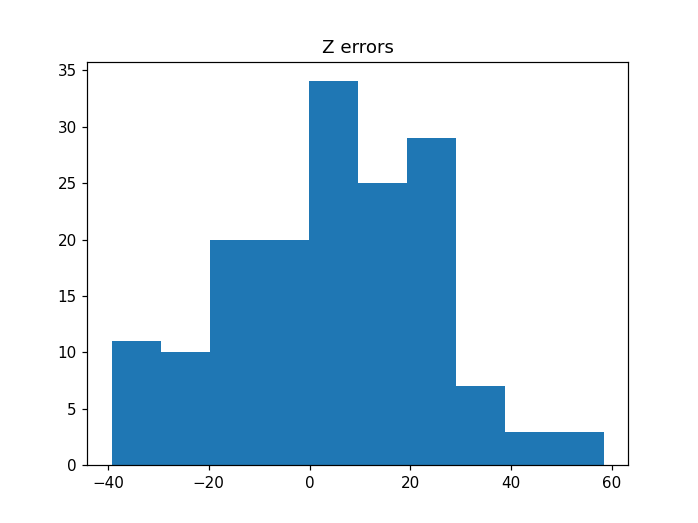

In [62]:
plt.figure()
plt.hist(new_points[:,0]-flattened_arteries[:,0])
plt.title('X errors')
plt.show()
plt.figure()
plt.hist(new_points[:,1]-flattened_arteries[:,1])
plt.title('Y errors')
plt.show()
plt.figure()
plt.hist(new_points[:,2]-flattened_arteries[:,2])
plt.title('Z errors')
plt.show()

#### artifical surface

In [64]:
eps_path = bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe.npy')
eps_save_path = bdir('manual_labels/'+name_prefix2+'_artificial_bottom_surface.npy')
which_surface = 'bottom' # if top, then we use z=0 as the surface, if 'bottom', find the appropriate z 
z_size = 2415-501 # this should be the shape z shape of the cropped movign zarr 


####
eps = np.load(eps_path)
eps_new = eps.copy()


if which_surface == 'top':
    diff = np.min(eps_new[:,2])
    eps_new[:,2] -= diff 
else:
    z = z_size - 1
    diff = z - np.max(eps_new[:,2]) # how much to add to each of the surface points 
    eps_new[:,2] += diff 

np.save(eps_save_path,eps_new)



#### 9. Warp

In [65]:
fixed_zarr_path = bdir(name_prefix+'_flattened.zarr') # We have to make this the fixed zarr so that it'll warp to the correct shape 
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_ptauwarp_new.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(16,)
chunks=3*(200,)
nb_workers = 12


# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_ptauwarp_cropped_new.npy')
use_grid_values_path = None


moving_pts_paths = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe.npy')]
fixed_pts_paths = [bdir('manual_labels/'+name_prefix+'_endpoints.npy')]

# anchor parameters (using the surface on the other  side and manually identified anchors on the cut surface)
static_pts_paths = [bdir('manual_labels/'+name_prefix2+'_artificial_bottom_surface.npy')] 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

##########################
zadd=np.maximum(0,zarr.open(fixed_zarr_path).shape[2]-zarr.open(moving_zarr_path).shape[2])


TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path, zadd=zadd, 
          grid_spacing=grid_spacing, smooth=2, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
# Test parallel convert zarr to tiff 
zrange = None
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=24, zrange=zrange)

(2651, 1347, 2000)
Fitting radial basis function...
Fitting rbf took 0.045530 seconds
Nonrigid ave. distance [pixels]: 0.0045089375762767244
Warping grid...
Warping grid took 57.287539 seconds
Saved grid_values at /mnt/share3/webster/mEhmAD_1-3_real/warping_grids/grid_ptauwarp_cropped_allpoints.npy
Warping image...
Moving image size: 17.255598096 GB


100%|██████████| 980/980 [02:22<00:00,  6.89it/s]


Time elapsed: 5.934533 minutes
Loading z 0 - 200


100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


Loading z 200 - 400


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


Loading z 400 - 600


100%|██████████| 200/200 [00:14<00:00, 14.20it/s]


Loading z 600 - 800


100%|██████████| 200/200 [00:14<00:00, 14.11it/s]


Loading z 800 - 1000


100%|██████████| 200/200 [00:14<00:00, 13.97it/s]


Loading z 1000 - 1200


100%|██████████| 200/200 [00:14<00:00, 13.77it/s]


Loading z 1200 - 1400


100%|██████████| 200/200 [00:14<00:00, 13.97it/s]


Loading z 1400 - 1600


100%|██████████| 200/200 [00:14<00:00, 14.26it/s]


Loading z 1600 - 1800


100%|██████████| 200/200 [00:14<00:00, 14.03it/s]


Loading z 1800 - 2000


100%|██████████| 200/200 [00:14<00:00, 13.95it/s]


In [58]:
numpy_to_json(np.load(bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy')),
             bdir('manual_labels/'+name_prefix+'_endpoints_ransac.json'))

# Rewarp with new points

In [47]:
anchors_json_path = bdir('manual_labels/ptau_labels_cropped_r2.json')
annotation_names = ['1-pts']
resample_factor = (1,)*3 # multiply this by the anchor points to get to correct reference frame 
offset = (0,0,1500) # subtract these to get the actual reference frame (subtracted pre-resampling)
surf_eps_save_path = bdir('manual_labels/'+name_prefix+'_endpoints_r2.npy') # where to save surface points 

# ranges for filtering (not downsampled)
xrange = None
yrange = None
zrange = None



##############################
pts = np.zeros((0,3),dtype='float')
for annotation_name in annotation_names:
    pts_temp = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
    pts = np.concatenate((pts,pts_temp),axis=0)

if xrange is not None:
    pts = pts[(pts[:,0]>=xrange[0]) * (pts[:,0]<xrange[1])]
if yrange is not None:
    pts = pts[(pts[:,1]>=yrange[0]) * (pts[:,1]<yrange[1])]
if zrange is not None:
    pts = pts[(pts[:,2]>=zrange[0]) * (pts[:,2]<zrange[1])]

pts[:,0] -= offset[0]; pts[:,1] -= offset[1]; pts[:,2] -= offset[2]
pts[:,0] *= resample_factor[0]; pts[:,1] *= resample_factor[1]; pts[:,2] *= resample_factor[2]
pts = np.round(pts).astype('int')

np.save(surf_eps_save_path, pts)
print(pts.shape)

print(pts[:,0].min(),pts[:,0].max())
print(pts[:,1].min(),pts[:,1].max())
print(pts[:,2].min(),pts[:,2].max())
pts_ = pts.copy()

(69, 3)
40 1897
149 1094
97 149


In [48]:
anchors_json_path = bdir('manual_labels/ptau_labels_cropped_r2.json')
annotation_names = ['3-pts']
resample_factor = (1,)*3 # multiply this by the anchor points to get to correct reference frame 
offset = (0,0,1500) # subtract these to get the actual reference frame (subtracted pre-resampling)
surf_eps_save_path = bdir('manual_labels/'+name_prefix2+'_endpoints_r2.npy') # where to save surface points 

# ranges for filtering (not downsampled)
xrange = None
yrange = None
zrange = None



##############################
pts = np.zeros((0,3),dtype='float')
for annotation_name in annotation_names:
    pts_temp = read_annotations_json(anchors_json_path, annotation_name, sink_path=None)
    pts = np.concatenate((pts,pts_temp),axis=0)

if xrange is not None:
    pts = pts[(pts[:,0]>=xrange[0]) * (pts[:,0]<xrange[1])]
if yrange is not None:
    pts = pts[(pts[:,1]>=yrange[0]) * (pts[:,1]<yrange[1])]
if zrange is not None:
    pts = pts[(pts[:,2]>=zrange[0]) * (pts[:,2]<zrange[1])]

pts[:,0] -= offset[0]; pts[:,1] -= offset[1]; pts[:,2] -= offset[2]
pts[:,0] *= resample_factor[0]; pts[:,1] *= resample_factor[1]; pts[:,2] *= resample_factor[2]
pts = np.round(pts).astype('int')

np.save(surf_eps_save_path, pts)
print(pts.shape)

print(pts[:,0].min(),pts[:,0].max())
print(pts[:,1].min(),pts[:,1].max())
print(pts[:,2].min(),pts[:,2].max())

(69, 3)
29 1872
151 1090
110 151


In [49]:
# Warp the moving points back to flattened frame 
grid_path = bdir('warping_grids/grid_ptauwarp_cropped_new.npy')

pts_path = bdir('manual_labels/'+name_prefix2+'_endpoints_r2.npy')
warped_zarr_path = bdir(name_prefix2+'_flattened_ptauwarp_new.zarr')
save_path = bdir('manual_labels/'+name_prefix2+'_endpoints_r2_flatframe.npy')
save_json = False 
inverse_transform = False


#####
g = np.load(pts_path)
#g[:,0] += 5759; g[:,1] += 5981; g[:,2] += 4213 # since the points were already cropped

coords = grid_transform_pts(grid_path, g, warped_zarr_path, save_path=save_path, save_json=save_json, inverse_transform=inverse_transform)# Transform moving points to flattened frame 

In [62]:
points_idxs_to_evaluate = None # new points to evaluate with RANSAC. Else, make None

moving_pts_paths = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.npy'),
                   bdir('manual_labels/'+name_prefix2+'_endpoints_r2_flatframe.npy')]
fixed_pts_paths =  [bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy'),
                   bdir('manual_labels/'+name_prefix+'_endpoints_r2.npy')]


moving_save_path = bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_r2_ransac.npy')
fixed_save_path = bdir('manual_labels/'+name_prefix+'_endpoints_r2_ransac.npy')
error_threshold = 25
min_samples = None

radius = 400
voxel_size = (1,1.414,1)


##################
moving_ransac, fixed_ransac = apply_ransac_v2(moving_pts_paths, fixed_pts_paths, moving_save_path=moving_save_path, fixed_save_path=fixed_save_path, points_idxs_to_evaluate=points_idxs_to_evaluate,
                    error_threshold=error_threshold, min_samples=min_samples, radius=radius, voxel_size=voxel_size)

print(np.load(moving_pts_paths[0]).shape,moving_ransac.shape)

29it [00:00, 149.13it/s]

4
4
4
4


184it [00:01, 141.48it/s]

(115, 3) (140, 3)


#### 8. Rigid alignment

(140, 3) (140, 3)
-2.808244693656859


<IPython.core.display.Javascript object>


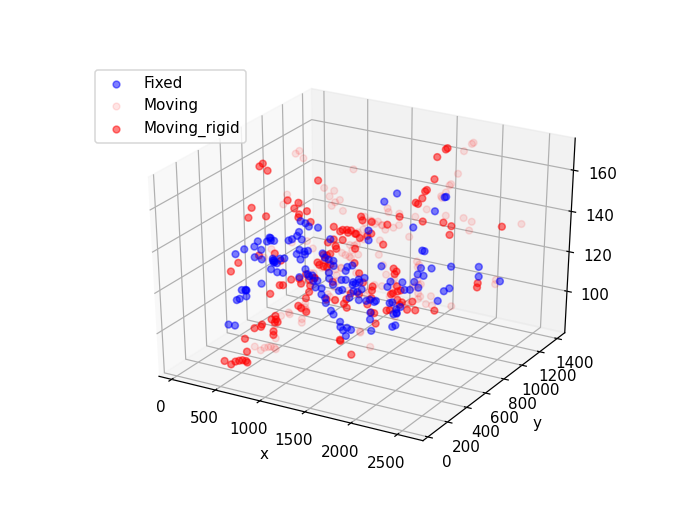

[[ 0.99740661 -0.07197255  0.        ]
 [ 0.07197255  0.99740661  0.        ]
 [ 0.          0.          1.        ]] [ -40.83214084 -264.99127403   -2.80824469]
average error: 30.831375099536075
average std: 13.187066421282648


In [63]:
# First do rigid alignment again

plot2d = False #True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
# flattened_arteries_paths = [bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy'),
#                    bdir('manual_labels/'+name_prefix+'_endpoints_r2.npy')]
# flattened_arteries_paths2 = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.npy'),
#                    bdir('manual_labels/'+name_prefix2+'_endpoints_r2_flatframe.npy')]
flattened_arteries_paths = [bdir('manual_labels/'+name_prefix+'_endpoints_r2_ransac.npy')]
flattened_arteries_paths2 = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_r2_ransac.npy')]
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    #b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],flattened_arteries_2[:,2],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')
print(R,b)
print("average error:",np.mean(np.linalg.norm(new_points-flattened_arteries,axis=1)))
print("average std:",np.std(np.linalg.norm(new_points-flattened_arteries,axis=1)))

<IPython.core.display.Javascript object>


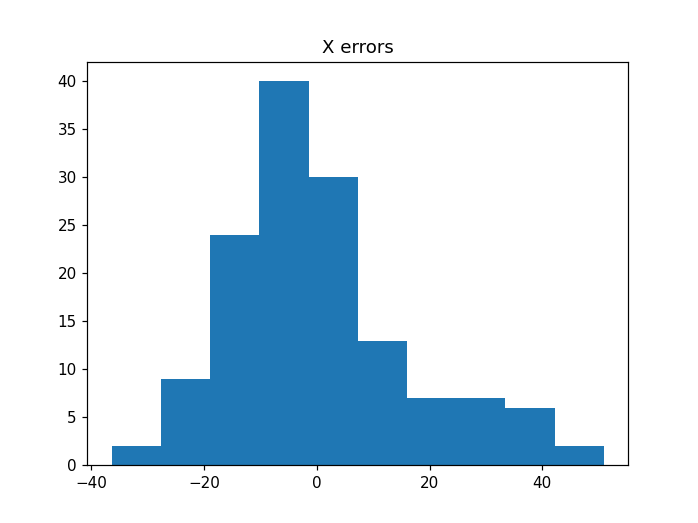

<IPython.core.display.Javascript object>


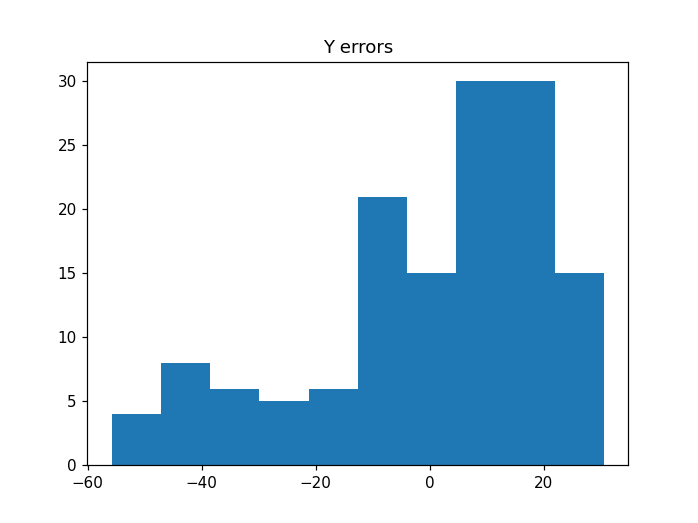

<IPython.core.display.Javascript object>


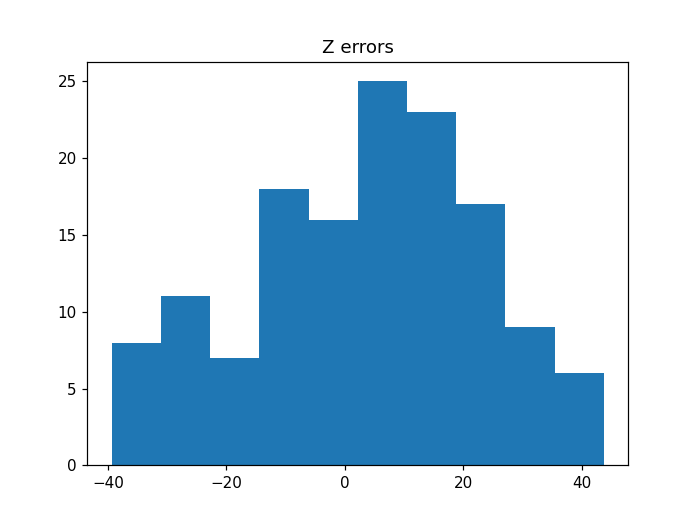

In [64]:
plt.figure()
plt.hist(new_points[:,0]-flattened_arteries[:,0])
plt.title('X errors')
plt.show()
plt.figure()
plt.hist(new_points[:,1]-flattened_arteries[:,1])
plt.title('Y errors')
plt.show()
plt.figure()
plt.hist(new_points[:,2]-flattened_arteries[:,2])
plt.title('Z errors')
plt.show()

#### 9. Warp

In [65]:
fixed_zarr_path = bdir(name_prefix+'_flattened.zarr') # We have to make this the fixed zarr so that it'll warp to the correct shape 
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_ptauwarp_new_r2.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(16,)
chunks=3*(200,)
nb_workers = 8


# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_ptauwarp_cropped_new_r2.npy')
use_grid_values_path = None


moving_pts_paths = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_r2_ransac.npy')]
fixed_pts_paths = [bdir('manual_labels/'+name_prefix+'_endpoints_r2_ransac.npy')]

# anchor parameters (using the surface on the other  side and manually identified anchors on the cut surface)
static_pts_paths = [bdir('manual_labels/'+name_prefix2+'_artificial_bottom_surface.npy')] 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

##########################
zadd=np.maximum(0,zarr.open(fixed_zarr_path).shape[2]-zarr.open(moving_zarr_path).shape[2])


TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path, zadd=zadd, 
          grid_spacing=grid_spacing, smooth=10, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
# Test parallel convert zarr to tiff 
zrange = None
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=24, zrange=zrange)

(2651, 1347, 2000)
Fitting radial basis function...
Fitting rbf took 0.038617 seconds
Nonrigid ave. distance [pixels]: 0.033530346929967494
Warping grid...
Warping grid took 53.297840 seconds
Saved grid_values at /mnt/share3/webster/mEhmAD_1-3_real/warping_grids/grid_ptauwarp_cropped_new_r2.npy
Warping image...
Moving image size: 17.255598096 GB


100%|██████████| 980/980 [02:24<00:00,  6.80it/s]


Time elapsed: 5.935843 minutes
Loading z 0 - 200


100%|██████████| 200/200 [00:19<00:00, 10.01it/s]


Loading z 200 - 400


100%|██████████| 200/200 [00:19<00:00, 10.46it/s]


Loading z 400 - 600


100%|██████████| 200/200 [00:18<00:00, 10.69it/s]


Loading z 600 - 800


100%|██████████| 200/200 [00:18<00:00, 10.57it/s]


Loading z 800 - 1000


100%|██████████| 200/200 [00:18<00:00, 10.64it/s]


Loading z 1000 - 1200


100%|██████████| 200/200 [00:19<00:00, 10.10it/s]


Loading z 1200 - 1400


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


Loading z 1400 - 1600


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]


Loading z 1600 - 1800


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]


Loading z 1800 - 2000


100%|██████████| 200/200 [00:18<00:00, 10.98it/s]


In [66]:
numpy_to_json(np.load(bdir('manual_labels/'+name_prefix+'_endpoints_r2_ransac.npy')),
             bdir('manual_labels/'+name_prefix+'_endpoints_r2_ransac.json'))

In [71]:
# view everything in flattened frame

numpy_to_json(np.load(bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy')),
             bdir('manual_labels/'+name_prefix+'_endpoints_ransac.json'))

numpy_to_json(np.load(bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.npy')),
             bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.json'))

In [69]:
np.load(bdir('manual_labels/'+name_prefix+'_endpoints.npy'))

array([[1905,  284,  126],
       [1845,  281,  126],
       [1905,  268,  126],
       [1750,  360,  125],
       [1811,  370,  123],
       [1726,  393,  118],
       [1610,  126,  115],
       [1529,  138,  126],
       [2469,  181,  142],
       [2495,  179,  139],
       [1672,  679,  104],
       [1645,  692,  101],
       [1727,  648,  100],
       [1451,  436,  118],
       [1367,  437,  124],
       [1527,  343,  107],
       [1558,  373,  108],
       [1542,  318,  104],
       [1476,  350,  105],
       [1411,  291,  116],
       [1453,  278,  115],
       [1361,  280,  122],
       [1711,  450,  116],
       [1720,  466,  116],
       [2119,  346,  135],
       [2128,  360,  131],
       [2432,  830,  130],
       [2427,  837,  125],
       [2517,  888,  133],
       [2142,  795,  128],
       [2154,  812,  128],
       [1752,  842,  112],
       [1859,  877,  111],
       [1818,  934,  120],
       [1678,  905,  127],
       [1692,  954,  127],
       [1719,  952,  127],
 

In [5]:
a = np.load(bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac.npy'))
b = np.load(bdir('manual_labels/'+name_prefix+'_endpoints_ransac.npy'))
print(a.shape, b.shape)

(115, 3) (115, 3)


In [7]:
print(a[:,2].max(), b[:,2].max())
a[:,2] += 4
b[:,2] -= 4
print(a[:,2].max(), b[:,2].max()) # originally did +3, -2

np.save(bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac_zedit4.npy'), a)
np.save(bdir('manual_labels/'+name_prefix+'_endpoints_ransac_zedit4.npy'), b)

172.12207100792978 147
176.12207100792978 143


(115, 3) (115, 3)
-14.460056093505884


<IPython.core.display.Javascript object>


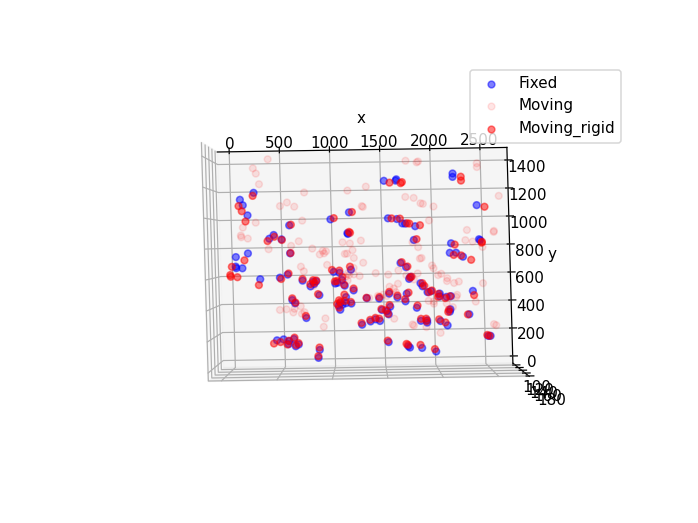

[[ 0.99682442 -0.07963086  0.        ]
 [ 0.07963086  0.99682442  0.        ]
 [ 0.          0.          1.        ]] [ -37.76408642 -273.37954397  -14.46005609]
average error: 32.547362468097916
average std: 15.224390674373566


In [8]:
# First do rigid alignment again

plot2d = False #True # if Flase, plot 3d 
use2d = True # don't use 3d, the nonplanar rotation is too sensitive to the endpoint detection
flattened_arteries_paths = [bdir('manual_labels/'+name_prefix+'_endpoints_ransac_zedit4.npy')]
flattened_arteries_paths2 = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac_zedit4.npy')]
make_json = False 


###############################################

flattened_arteries = np.zeros((0,3),dtype='int')
flattened_arteries_2 = np.zeros((0,3),dtype='int')
for i in range(len(flattened_arteries_paths)):
    flattened_arteries = np.concatenate((flattened_arteries,np.load(flattened_arteries_paths[i])),axis=0)
    flattened_arteries_2 = np.concatenate((flattened_arteries_2,np.load(flattened_arteries_paths2[i])),axis=0)

print(flattened_arteries.shape, flattened_arteries_2.shape)
# if doing 2d
if use2d:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2[:,:2]), np.transpose(flattened_arteries[:,:2]))
    new_pts = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2[:,:2])) + b)
    new_points = np.concatenate((new_pts,flattened_arteries_2[:,2:3]),axis=1) # add in the z coordinate
    
    # needs to be 3x3 for future transforms
    Rn = np.zeros((3,3))
    Rn[:2,:2] = R
    Rn[2,2] = 1
    bn = np.zeros((3,))
    bn[:2] = b[:,0]
    
    # compute the approximate z translation 
    zadd = np.mean(flattened_arteries[:,2] - flattened_arteries_2[:,2])
    bn[2] = zadd 
    print(zadd)
    R = Rn
    b = bn
    
# 3d
else:
    R,b = rigid_transform_3D(np.transpose(flattened_arteries_2), np.transpose(flattened_arteries))
    new_points = np.transpose(np.matmul(R,np.transpose(flattened_arteries_2)) + b)
    print(b)
    # we don't want to screw with the z coordinate translation
    #b[2] = 0

np.save(bdir('R.npy'), R)
np.save(bdir('b.npy'), b.squeeze())

# 2D
fig = plt.figure()

if plot2d:
    ax = fig.add_subplot(1,1,1)#,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],antialiased=True, alpha=0.1, color='r')
    ax.scatter(new_points[:,0],new_points[:,1],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])

#3d
else:
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.scatter(flattened_arteries[:,0],flattened_arteries[:,1],flattened_arteries[:,2],antialiased=True, alpha=0.5, color='b')
    ax.scatter(flattened_arteries_2[:,0],flattened_arteries_2[:,1],flattened_arteries_2[:,2],antialiased=True, alpha=0.1,color='r')
    ax.scatter(new_points[:,0],new_points[:,1],new_points[:,2],antialiased=True,alpha=0.5,color='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(['Fixed','Moving','Moving_rigid'])
    
if make_json:
    numpy_to_json(flattened_arteries, flattened_arteries_path[:-4]+'.json')
    numpy_to_json(flattened_arteries_2, flattened_arteries_path2[:-4]+'.json')
print(R,b)
print("average error:",np.mean(np.linalg.norm(new_points-flattened_arteries,axis=1)))
print("average std:",np.std(np.linalg.norm(new_points-flattened_arteries,axis=1)))

In [9]:
fixed_zarr_path = bdir(name_prefix+'_flattened.zarr') # We have to make this the fixed zarr so that it'll warp to the correct shape 
moving_zarr_path = bdir(name_prefix2+'_flattened.zarr')
warped_zarr_path = bdir(name_prefix2+'_flattened_ptauwarp_new_r2.zarr')

# Parameters for TPS zarr warp
grid_spacing = 3*(16,)
chunks=3*(200,)
nb_workers = 8


# grid I/O 
save_grid_values_path = bdir('warping_grids/grid_ptauwarp_cropped_new_r2.npy')
use_grid_values_path = None


moving_pts_paths = [bdir('manual_labels/'+name_prefix2+'_endpoints_flatframe_ransac_zedit4.npy')]
fixed_pts_paths = [bdir('manual_labels/'+name_prefix+'_endpoints_ransac_zedit4.npy')]

# anchor parameters (using the surface on the other  side and manually identified anchors on the cut surface)
static_pts_paths = [bdir('manual_labels/'+name_prefix2+'_artificial_bottom_surface.npy')] 

# affine parameters 
R_path = bdir('R.npy')
b_path = bdir('b.npy')

##########################
zadd=np.maximum(0,zarr.open(fixed_zarr_path).shape[2]-zarr.open(moving_zarr_path).shape[2])


TPS_warp(moving_zarr_path, fixed_zarr_path, warped_zarr_path, moving_pts_paths, fixed_pts_paths,
         static_pts_paths=static_pts_paths, R_path=R_path, b_path=b_path, zadd=zadd, 
          grid_spacing=grid_spacing, smooth=10, chunks=chunks,
          nb_workers=nb_workers, padding=2, save_grid_values_path=save_grid_values_path, 
          show_residuals=True, use_grid_values_path=use_grid_values_path)

# Convert zarr to tiff
# Test parallel convert zarr to tiff 
zrange = None
tiff_path = warped_zarr_path[:-5]+'_tiffs'
convert_zarr_to_tiff(warped_zarr_path, tiff_path, num_workers=24, zrange=zrange)

(2651, 1347, 2000)
Fitting radial basis function...
Fitting rbf took 0.035644 seconds
Nonrigid ave. distance [pixels]: 0.010030548443254675
Warping grid...
Warping grid took 48.470372 seconds
Saved grid_values at /mnt/share3/webster/mEhmAD_1-3_real/warping_grids/grid_ptauwarp_cropped_new_r2.npy
Warping image...
Moving image size: 17.255598096 GB


100%|██████████| 980/980 [03:14<00:00,  5.04it/s]


Time elapsed: 7.112383 minutes
Loading z 0 - 200


100%|██████████| 200/200 [00:20<00:00,  9.67it/s]


Loading z 200 - 400


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]


Loading z 400 - 600


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]


Loading z 600 - 800


100%|██████████| 200/200 [00:20<00:00,  9.93it/s]


Loading z 800 - 1000


100%|██████████| 200/200 [00:19<00:00, 10.29it/s]


Loading z 1000 - 1200


100%|██████████| 200/200 [00:20<00:00,  9.98it/s]


Loading z 1200 - 1400


100%|██████████| 200/200 [00:19<00:00, 10.21it/s]


Loading z 1400 - 1600


100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


Loading z 1600 - 1800


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]


Loading z 1800 - 2000


100%|██████████| 200/200 [00:19<00:00, 10.02it/s]
